# Active Learning Experiment Analysis

This notebook visualizes and analyzes AL experiment outputs (learning curves, baselines, strategy comparisons and improvement over random).

Order: imports → paths → load → organize → baselines → curves → comparisons → heatmaps → improvement → export.

In [2]:
# Imports
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 10

In [3]:
# Paths (adjust if you placed outputs elsewhere)
experiments_dir = Path('../artifacts/embedding_cnn/al_experiments')
baselines_path = experiments_dir / 'baseline_results.csv'
curves_path = experiments_dir / 'all_al_curves.csv'
metadata_path = experiments_dir / 'experiment_metadata.json'
print('Experiments dir:', experiments_dir.resolve())
print('Exists:', experiments_dir.exists())

Experiments dir: D:\Projects\al-synthetic\artifacts\embedding_cnn\al_experiments
Exists: True


In [4]:
# Load files if present
baselines_df = pd.read_csv(baselines_path) if baselines_path.exists() else None
curves_df = pd.read_csv(curves_path) if curves_path.exists() else None
metadata = json.loads(metadata_path.read_text()) if metadata_path.exists() else None
print('baselines:', baselines_path.exists(), 'curves:', curves_path.exists(), 'metadata:', metadata_path.exists())

baselines: True curves: True metadata: True


# Example Images for Each Class
Below are one example image for each class in the dataset.

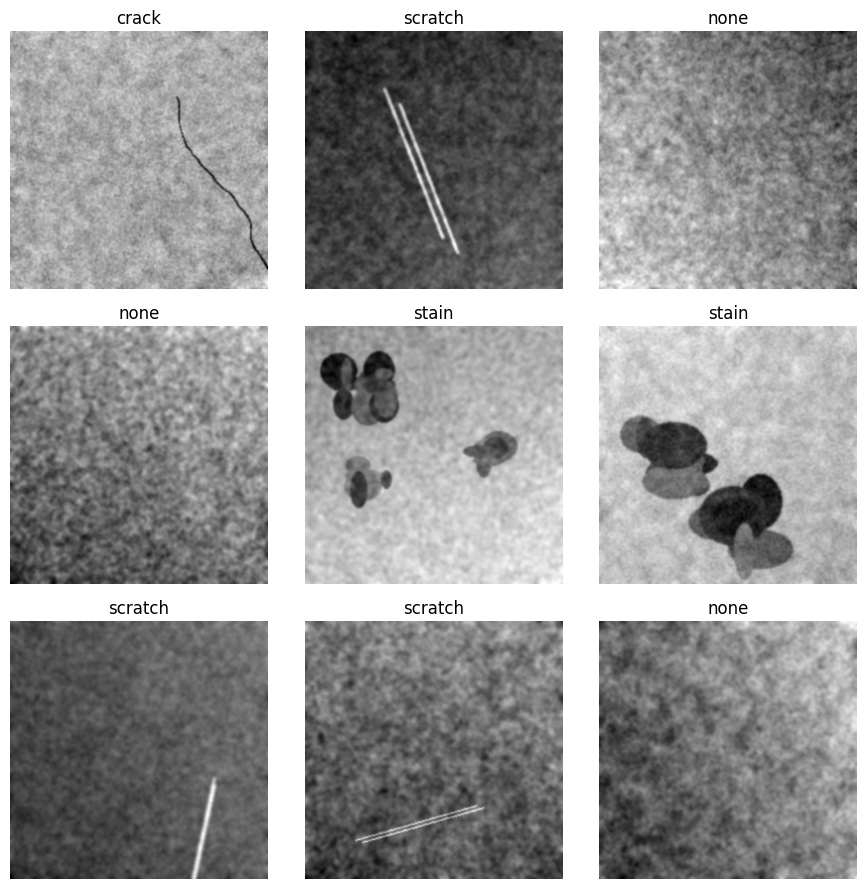

In [3]:
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Load metadata
meta = pd.read_csv('../data/synth_surface_defects/metadata.csv')

# Take 9 random images from the dataset
examples = meta.sample(n=9, random_state=42).reset_index()

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, (_, row) in zip(axes.flatten(), examples.iterrows()):
    img_path = Path('../data/synth_surface_defects') / row['filepath']
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(row['label'])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Parse and quick sanity checks

In [5]:
# Quick inspection
if curves_df is not None:
    print('AL curves columns:', list(curves_df.columns))
    display(curves_df.head())
else:
    print('No AL curves found; run experiments first.')

if baselines_df is not None:
    display(baselines_df)
else:
    print('No baseline results found.')

AL curves columns: ['strategy', 'diversity', 'classifier', 'round', 'labeled_size', 'test_accuracy', 'test_f1_macro']


,strategy,diversity,classifier,round,labeled_size,test_accuracy,test_f1_macro
0,random,False,logreg,1,2,0.000000,0.000000
1,random,False,logreg,2,3,0.375000,0.214754
2,random,False,logreg,3,4,0.256818,0.081736
3,random,False,logreg,4,5,0.256818,0.081736
4,random,False,logreg,5,6,0.388636,0.267150


,classifier,accuracy,f1_macro,precision_macro,recall_macro,n_train_samples
0,logreg,0.9455,0.9459,0.9481,0.9442,2165
1,random_forest,0.9568,0.9565,0.9585,0.9554,2165
2,svc,0.9545,0.9535,0.9557,0.9518,2165
3,gbdt,0.9545,0.9538,0.9546,0.9536,2165


## Baseline metrics (full training set)

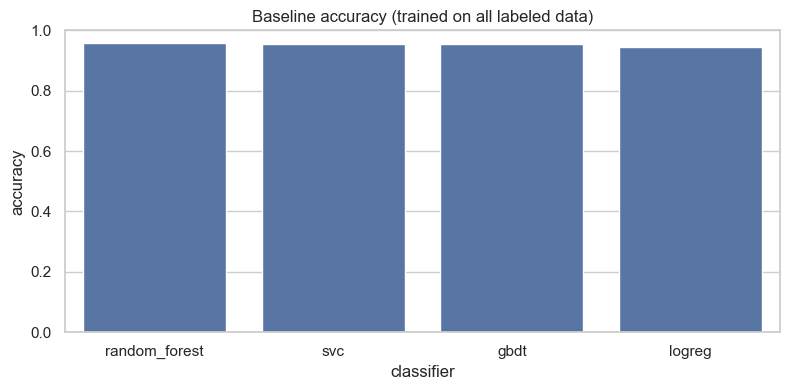

In [6]:
if baselines_df is not None:
    plt.figure(figsize=(8,4))
    sns.barplot(data=baselines_df.sort_values('accuracy', ascending=False), x='classifier', y='accuracy')
    plt.title('Baseline accuracy (trained on all labeled data)')
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()
else:
    print('Baselines missing.')

## Learning curves by classifier

<Figure size 800x400 with 0 Axes>

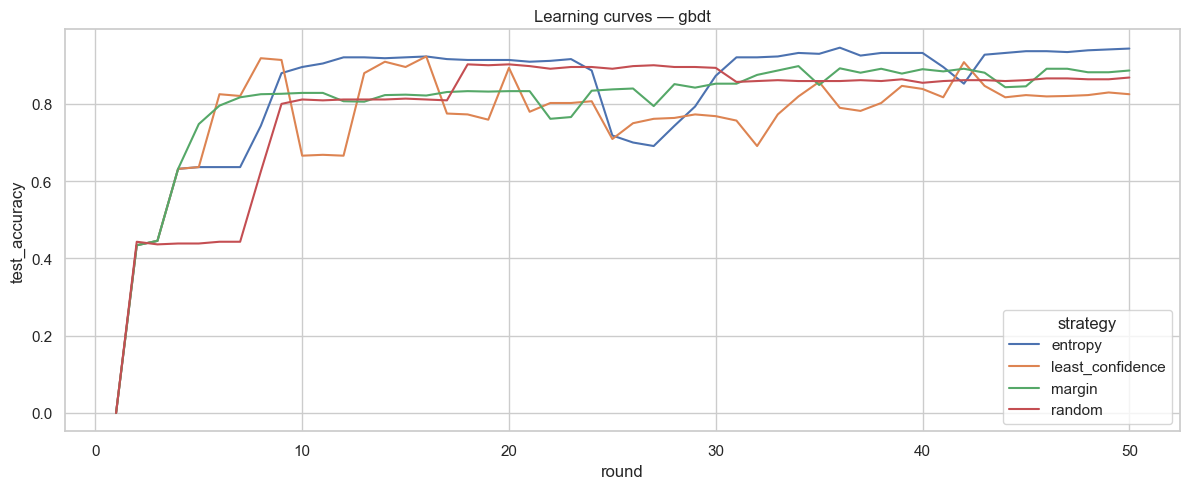

<Figure size 800x400 with 0 Axes>

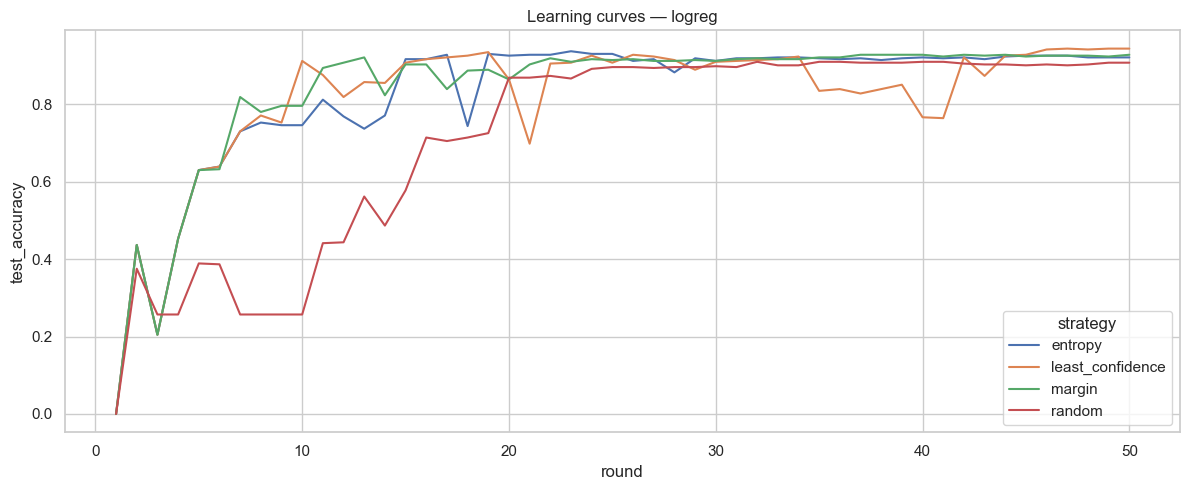

<Figure size 800x400 with 0 Axes>

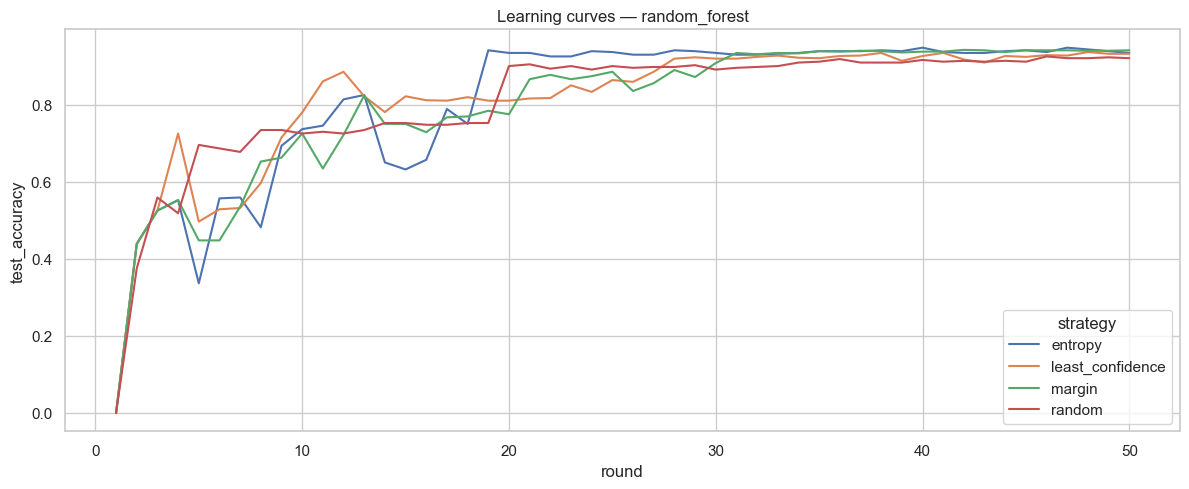

<Figure size 800x400 with 0 Axes>

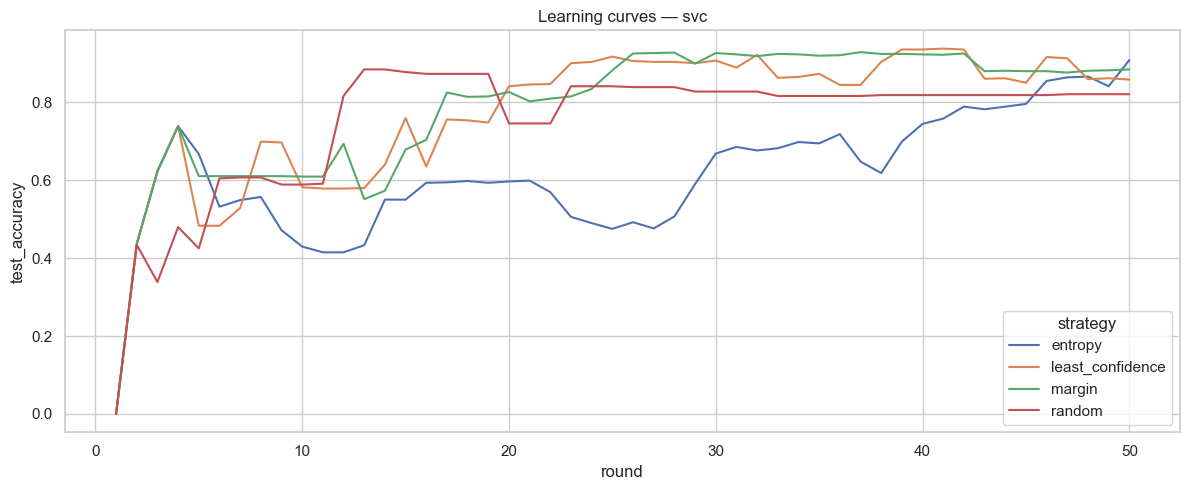

In [7]:
if curves_df is not None:
    for clf, g in curves_df.groupby('classifier'):
        pivot = g.pivot_table(index='round', columns='strategy', values='test_accuracy')
        plt.figure(figsize=(8,4))
        pivot.plot(title=f'Learning curves — {clf}', xlabel='round', ylabel='test_accuracy')
        plt.legend(title='strategy')
        plt.tight_layout()
        plt.show()
else:
    print('No curves to plot.')

## Compare sampling strategies (aggregate)

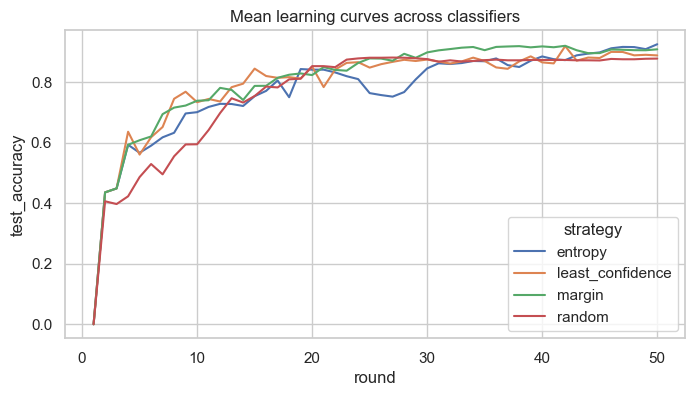

In [8]:
if curves_df is not None:
    agg = curves_df.groupby(['strategy','round'])['test_accuracy'].mean().reset_index()
    plt.figure(figsize=(8,4))
    sns.lineplot(data=agg, x='round', y='test_accuracy', hue='strategy')
    plt.title('Mean learning curves across classifiers')
    plt.show()
else:
    print('No curves for aggregation.')

## Final-round heatmap: accuracy by classifier × strategy

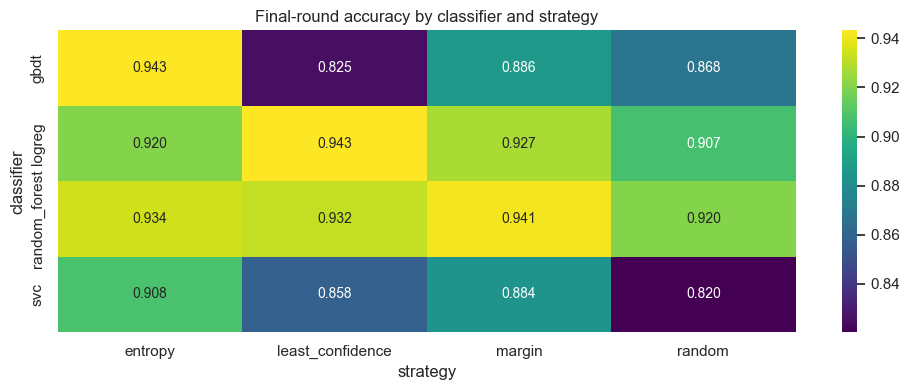

In [9]:
if curves_df is not None:
    last_round = curves_df['round'].max()
    final = curves_df[curves_df['round'] == last_round].copy()
    pivot_final = final.pivot_table(index='classifier', columns='strategy', values='test_accuracy')
    plt.figure(figsize=(10,4))
    sns.heatmap(pivot_final, annot=True, fmt='.3f', cmap='viridis')
    plt.title('Final-round accuracy by classifier and strategy')
    plt.tight_layout()
    plt.show()
else:
    print('No final results available.')

## Improvement over random (final round)

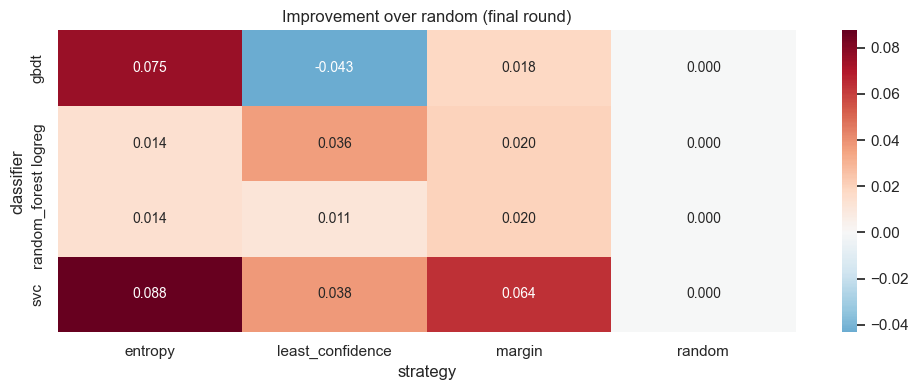

In [10]:
if curves_df is not None:
    last_round = curves_df['round'].max()
    final = curves_df[curves_df['round'] == last_round].copy()
    rnd = final[final['strategy']=='random'][['classifier','test_accuracy']].rename(columns={'test_accuracy':'random_acc'})
    merged_final = final.merge(rnd, on='classifier', how='left')
    merged_final['improvement_over_random'] = merged_final['test_accuracy'] - merged_final['random_acc']
    pivot_imp = merged_final.pivot_table(index='classifier', columns='strategy', values='improvement_over_random')
    plt.figure(figsize=(10,4))
    sns.heatmap(pivot_imp, annot=True, fmt='.3f', center=0, cmap='RdBu_r')
    plt.title('Improvement over random (final round)')
    plt.tight_layout()
    plt.show()
else:
    print('No curves to compare to random.')

## Summary and export

In [11]:
if 'merged_final' in globals():
    summary = merged_final.groupby('strategy').agg(mean_final_acc=('test_accuracy','mean'), mean_imp_over_random=('improvement_over_random','mean')).reset_index()
    display(summary.sort_values('mean_final_acc', ascending=False))
    out_dir = experiments_dir / 'analysis_outputs'
    out_dir.mkdir(parents=True, exist_ok=True)
    summary.to_csv(out_dir / 'strategy_summary.csv', index=False)
    pivot_final.to_csv(out_dir / 'final_accuracy_matrix.csv')
    pivot_imp.to_csv(out_dir / 'improvement_over_random_matrix.csv')
    print('Wrote summary files to', out_dir)
else:
    print('Nothing to export; run previous cells first.')

,strategy,mean_final_acc,mean_imp_over_random
0,entropy,0.926420,0.047443
2,margin,0.909659,0.030682
1,least_confidence,0.889489,0.010511
3,random,0.878977,0.000000


Wrote summary files to ..\artifacts\embedding_cnn\al_experiments\analysis_outputs
